In [36]:
mapping_colnames = {'Homocystéine (µmol/L)' : 'Homocystéine',
'TSH (mUI/L)' : 'TSH',
'Ferritine (µg/L)' : 'Ferritine',
'LBP (µg/mL)': 'LBP',
'Vitamine D (ng/mL)' : 'VitamineD'}
import pandas as pd
df = pd.read_csv('peggy/data/peggy_clean.csv')
df = df.rename(columns=mapping_colnames)
variables = ['Homocystéine', 'TSH', 'Ferritine', 'LBP', 'VitamineD']


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

class ClusterDataExporter:
    def __init__(self, data_file=None, dataframe=None, variables=None):
        """
        Initialize with your data file or DataFrame and specify variables for clustering
        
        Parameters:
        data_file: str, path to your CSV file with quantitative variables
        dataframe: pd.DataFrame, DataFrame containing your data (alternative to data_file)
        variables: list, specific column names to use for clustering (if None, uses all numeric columns)
        
        Examples:
        # With CSV file and specific variables
        exporter = ClusterDataExporter(data_file='data.csv', variables=['var1', 'var2', 'var3'])
        
        # With DataFrame and all numeric columns
        exporter = ClusterDataExporter(dataframe=my_df)
        
        # With DataFrame and specific variables
        exporter = ClusterDataExporter(dataframe=my_df, variables=['col1', 'col2', 'col3', 'col4', 'col5'])
        """
        
        self.original_data = None  # Store original data
        self.clustering_variables = variables  # Store specified variables
        
        # Load data from file or DataFrame
        if dataframe is not None:
            if not isinstance(dataframe, pd.DataFrame):
                raise ValueError("dataframe parameter must be a pandas DataFrame")
            self.original_data = dataframe.copy()
            print(f"Data loaded from DataFrame - Shape: {self.original_data.shape}")
        elif data_file:
            try:
                self.original_data = pd.read_csv(data_file)
                print(f"Data loaded successfully from {data_file} - Shape: {self.original_data.shape}")
            except FileNotFoundError:
                print(f"Error: File '{data_file}' not found.")
                print("Generating sample data for demonstration...")
                self.original_data = self.generate_sample_data()
            except Exception as e:
                print(f"Error reading file: {e}")
                print("Generating sample data for demonstration...")
                self.original_data = self.generate_sample_data()
        else:
            # Generate sample data for testing
            print("No data provided. Generating sample data for demonstration...")
            self.original_data = self.generate_sample_data()
        
        # Prepare clustering data
        self.data = self.prepare_clustering_data()
        
        self.scaled_data = None
        self.clustered_data = {}
        self.scaler = None
        
        # Validate final clustering data
        self.validate_data()
    
    def prepare_clustering_data(self):
        """Prepare data for clustering based on specified variables"""
        print(f"\n--- PREPARING CLUSTERING DATA ---")
        print(f"Original data shape: {self.original_data.shape}")
        print(f"Available columns: {list(self.original_data.columns)}")
        
        if self.clustering_variables is not None:
            # Use specified variables
            print(f"Specified variables for clustering: {self.clustering_variables}")
            
            # Check if all specified variables exist
            missing_vars = [var for var in self.clustering_variables if var not in self.original_data.columns]
            if missing_vars:
                raise ValueError(f"The following specified variables are not found in the data: {missing_vars}")
            
            # Select only specified variables
            clustering_data = self.original_data[self.clustering_variables].copy()
            
            # Check if variables are numeric
            non_numeric_vars = clustering_data.select_dtypes(exclude=[np.number]).columns.tolist()
            if non_numeric_vars:
                raise ValueError(f"The following specified variables are not numeric: {non_numeric_vars}")
                
        else:
            # Use all numeric columns
            numeric_cols = self.original_data.select_dtypes(include=[np.number]).columns.tolist()
            if len(numeric_cols) == 0:
                raise ValueError("No numeric columns found in the data")
            
            clustering_data = self.original_data[numeric_cols].copy()
            print(f"Using all numeric columns: {numeric_cols}")
        
        print(f"Final clustering data shape: {clustering_data.shape}")
        print(f"Variables used for clustering: {list(clustering_data.columns)}")
        
        return clustering_data
        
    def validate_data(self):
        """Validate that data contains only numeric columns"""
        print(f"--- DATA VALIDATION ---")
        print(f"Data shape: {self.data.shape}")
        print(f"Columns: {list(self.data.columns)}")
        
        # Check for numeric columns
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns
        non_numeric_cols = self.data.select_dtypes(exclude=[np.number]).columns
        
        if len(non_numeric_cols) > 0:
            print(f"Warning: Non-numeric columns found: {list(non_numeric_cols)}")
            print("These columns will be excluded from clustering.")
            self.data = self.data[numeric_cols]
        
        # Check for missing values
        missing_values = self.data.isnull().sum()
        if missing_values.any():
            print(f"Warning: Missing values found:")
            for col, count in missing_values[missing_values > 0].items():
                print(f"  {col}: {count} missing values")
            print("Missing values will be filled with column means.")
            self.data = self.data.fillna(self.data.mean())
        
        print(f"Final data shape for clustering: {self.data.shape}")
        
    def generate_sample_data(self, n_samples=300):
        """Generate sample data for testing"""
        np.random.seed(42)
        
        # Create 4 natural clusters for testing
        cluster1 = np.random.multivariate_normal([20, 30, 15, 25, 40], np.eye(5) * 20, 75)
        cluster2 = np.random.multivariate_normal([60, 70, 45, 65, 80], np.eye(5) * 25, 75)
        cluster3 = np.random.multivariate_normal([40, 20, 60, 30, 50], np.eye(5) * 15, 75)
        cluster4 = np.random.multivariate_normal([80, 40, 30, 80, 20], np.eye(5) * 30, 75)
        
        data = np.vstack([cluster1, cluster2, cluster3, cluster4])
        
        df = pd.DataFrame(data, columns=['Variable_1', 'Variable_2', 'Variable_3', 
                                       'Variable_4', 'Variable_5'])
        df = df.abs()  # Ensure positive values
        
        return df
    
    def preprocess_data(self):
        """Standardize the data"""
        print("Preprocessing data...")
        print(f"Original data shape: {self.data.shape}")
        print(f"Variables: {list(self.data.columns)}")
        
        # Check for infinite values
        if np.isinf(self.data.values).any():
            print("Warning: Infinite values found. Replacing with NaN and then mean.")
            self.data = self.data.replace([np.inf, -np.inf], np.nan)
            self.data = self.data.fillna(self.data.mean())
        
        self.scaler = StandardScaler()
        self.scaled_data = self.scaler.fit_transform(self.data)
        
        print("Data standardized successfully.")
        return self.scaler
    def descriptive_statistics(self):
        """Display descriptive statistics for all variables"""
        print("\n" + "="*60)
        print("DESCRIPTIVE STATISTICS")
        print("="*60)
        
        desc_stats = self.data.describe()
        print(desc_stats.round(3))
        
        # Correlation matrix
        print("\nCORRELATION MATRIX:")
        print("-"*40)
        corr_matrix = self.data.corr()
        print(corr_matrix.round(3))
        
        return desc_stats, corr_matrix

    def find_optimal_clusters(self, max_k=10):
        """Find optimal number of clusters using multiple methods"""
        if self.scaled_data is None:
            self.preprocess_data()
        
        print("\n" + "="*60)
        print("OPTIMAL NUMBER OF CLUSTERS ANALYSIS")
        print("="*60)
        
        k_range = range(2, max_k + 1)
        inertias = []
        silhouette_scores = []
        calinski_scores = []
        davies_bouldin_scores = []
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(self.scaled_data)
            
            inertias.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(self.scaled_data, labels))
            calinski_scores.append(calinski_harabasz_score(self.scaled_data, labels))
            davies_bouldin_scores.append(davies_bouldin_score(self.scaled_data, labels))
        
        # Print results
        results_df = pd.DataFrame({
            'K': k_range,
            'Inertia': inertias,
            'Silhouette': silhouette_scores,
            'Calinski-Harabasz': calinski_scores,
            'Davies-Bouldin': davies_bouldin_scores
        })
        
        print(results_df.round(3))
        
        # Find optimal k
        optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
        optimal_k_calinski = k_range[np.argmax(calinski_scores)]
        optimal_k_davies = k_range[np.argmin(davies_bouldin_scores)]
        
        print(f"\nOptimal K suggestions:")
        print(f"Silhouette Score: K = {optimal_k_silhouette}")
        print(f"Calinski-Harabasz: K = {optimal_k_calinski}")
        print(f"Davies-Bouldin: K = {optimal_k_davies}")
        
        return results_df

    
    def cluster_with_kmeans(self, n_clusters=4):
        """Perform K-means clustering with 4 clusters"""
        if self.scaled_data is None:
            self.preprocess_data()
        
        print(f"\n--- K-MEANS CLUSTERING (K={n_clusters}) ---")
        
        # Perform K-means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(self.scaled_data)
        
        # Create result dataframe - CORRECTION: Nom cohérent
        result_df = self.data.copy()
        result_df['Cluster_KMeans'] = cluster_labels  # Toujours KMeans avec K majuscule
        
        # Calculate quality metrics
        silhouette = silhouette_score(self.scaled_data, cluster_labels)
        calinski = calinski_harabasz_score(self.scaled_data, cluster_labels)
        davies_bouldin = davies_bouldin_score(self.scaled_data, cluster_labels)
        
        print(f"Silhouette Score: {silhouette:.3f}")
        print(f"Calinski-Harabasz Score: {calinski:.3f}")
        print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")
        
        # Show cluster distribution
        cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
        print(f"\nCluster distribution:")
        for cluster, count in cluster_counts.items():
            percentage = (count / len(cluster_labels)) * 100
            print(f"  Cluster {cluster}: {count} points ({percentage:.1f}%)")
        
        self.clustered_data['Cluster_KMeans'] = result_df
        return result_df
    
    def cluster_with_hierarchical(self, n_clusters=4, linkage='ward'):
        """Perform Hierarchical clustering with 4 clusters"""
        if self.scaled_data is None:
            self.preprocess_data()
        
        print(f"\n--- HIERARCHICAL CLUSTERING (K={n_clusters}, linkage={linkage}) ---")
        
        # Perform Hierarchical clustering
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        cluster_labels = hierarchical.fit_predict(self.scaled_data)
        
        # Create result dataframe
        result_df = self.data.copy()
        result_df['Cluster_Hierarchical'] = cluster_labels
        
        # Calculate quality metrics
        silhouette = silhouette_score(self.scaled_data, cluster_labels)
        calinski = calinski_harabasz_score(self.scaled_data, cluster_labels)
        davies_bouldin = davies_bouldin_score(self.scaled_data, cluster_labels)
        
        print(f"Silhouette Score: {silhouette:.3f}")
        print(f"Calinski-Harabasz Score: {calinski:.3f}")
        print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")
        
        # Show cluster distribution
        cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
        print(f"\nCluster distribution:")
        for cluster, count in cluster_counts.items():
            percentage = (count / len(cluster_labels)) * 100
            print(f"  Cluster {cluster}: {count} points ({percentage:.1f}%)")
        
        self.clustered_data['Cluster_Hierarchical'] = result_df
        return result_df
    
    def cluster_with_dbscan(self, eps=0.5, min_samples=5):
        """Perform DBSCAN clustering"""
        if self.scaled_data is None:
            self.preprocess_data()
        
        print(f"\n" + "="*60)
        print(f"DBSCAN CLUSTERING (eps={eps}, min_samples={min_samples})")
        print("="*60)
        
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(self.scaled_data)
        
        # Add cluster labels to original data
        result_df = self.data.copy()
        result_df['Cluster_Dbscan'] = labels
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        print(f"Number of clusters: {n_clusters}")
        print(f"Number of noise points: {n_noise}")
        
        if n_clusters > 1:
            # Calculate metrics (excluding noise points)
            mask = labels != -1
            if mask.sum() > 0:
                silhouette = silhouette_score(self.scaled_data[mask], labels[mask])
                calinski = calinski_harabasz_score(self.scaled_data[mask], labels[mask])
                davies_bouldin = davies_bouldin_score(self.scaled_data[mask], labels[mask])
                
                print(f"Silhouette Score: {silhouette:.3f}")
                print(f"Calinski-Harabasz Score: {calinski:.3f}")
                print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")
            
            # Cluster sizes
            cluster_sizes = pd.Series(labels).value_counts().sort_index()
            print(f"\nCluster Sizes:")
            for cluster_id, size in cluster_sizes.items():
                if cluster_id == -1:
                    print(f"Noise: {size} points ({size/len(labels)*100:.1f}%)")
                else:
                    print(f"Cluster {cluster_id}: {size} points ({size/len(labels)*100:.1f}%)")
        
        
        self.clustered_data['Cluster_Dbscan'] = result_df

        return result_df
    

    def get_all_clustered_data(self, n_clusters=4):
        """Get data with all clustering methods applied"""
        print("="*60)
        print("CLUSTERING WITH 4 CLUSTERS")
        print("="*60)
        
        # Apply both methods
        kmeans_result = self.cluster_with_kmeans(n_clusters)
        hierarchical_result = self.cluster_with_hierarchical(n_clusters)
        dbscan_result = self.cluster_with_dbscan()
        
        # Combine results
        final_result = self.data.copy()
        final_result['Cluster_KMeans'] = kmeans_result['Cluster_KMeans']
        final_result['Cluster_Hierarchical'] = hierarchical_result['Cluster_Hierarchical']
        final_result['Cluster_Dbscan'] = dbscan_result['Cluster_Dbscan']

        
        self.clustered_data['combined'] = final_result
        return final_result
    
    def show_cluster_profiles(self, method='kmeans'):
        """Show statistical profile of each cluster"""
        if method not in self.clustered_data:
            print(f"Method {method} not found. Run clustering first.")
            return
        
        data = self.clustered_data[method]
        
        # CORRECTION: Nom de colonne cohérent
        if method == 'kmeans':
            cluster_col = 'Cluster_KMeans'  # K majuscule
        elif method == 'hierarchical':
            cluster_col = 'Cluster_Hierarchical'
        elif method == 'combined':
            cluster_col = 'Cluster_KMeans'  # K majuscule
        else:
            print(f"Unknown method: {method}")
            return
        
        # Vérifier que la colonne existe
        if cluster_col not in data.columns:
            print(f"Column {cluster_col} not found in data.")
            print(f"Available columns: {list(data.columns)}")
            return
        
        print(f"\n--- CLUSTER PROFILES ({method.upper()}) ---")
        
        # Calculate profiles - exclure les colonnes de clusters
        numeric_cols = [col for col in data.columns if col not in ['Cluster_KMeans', 'Cluster_Hierarchical']]
        
        profiles = data.groupby(cluster_col)[numeric_cols].agg(['mean', 'std', 'count']).round(3)
        
        for cluster in sorted(data[cluster_col].unique()):
            print(f"\nCluster {cluster}:")
            for var in numeric_cols:
                mean_val = profiles.loc[cluster, (var, 'mean')]
                std_val = profiles.loc[cluster, (var, 'std')]
                count_val = int(profiles.loc[cluster, (var, 'count')])
                print(f"  {var}: {mean_val:.2f} ± {std_val:.2f} (n={count_val})")
    
    def get_results_with_original_data(self, method='kmeans'):
        """Get clustering results merged with original data (all columns)"""
        if method not in self.clustered_data:
            print(f"Method {method} not found. Run clustering first.")
            return None
        
        clustering_result = self.clustered_data[method]
        
        # Get cluster column name
        if method == 'kmeans':
            cluster_col = 'Cluster_KMeans'
        elif method == 'hierarchical':
            cluster_col = 'Cluster_Hierarchical'
        elif method == 'combined':
            # For combined, we'll add both cluster columns
            result_with_original = self.original_data.copy()
            result_with_original['Cluster_KMeans'] = clustering_result['Cluster_KMeans']
            result_with_original['Cluster_Hierarchical'] = clustering_result['Cluster_Hierarchical']
            return result_with_original
        else:
            print(f"Unknown method: {method}")
            return None
        
        # Merge with original data
        result_with_original = self.original_data.copy()
        result_with_original[cluster_col] = clustering_result[cluster_col]
        
        return result_with_original
    
    def save_clustered_data(self, filename=None, method='kmeans', include_all_columns=True):
        """
        Save clustered data to CSV file
        
        Parameters:
        filename: str, output filename
        method: str, clustering method ('kmeans', 'hierarchical', 'combined')
        include_all_columns: bool, if True includes all original columns, if False only clustering variables
        """
        if include_all_columns:
            # Get results with all original columns
            result_data = self.get_results_with_original_data(method)
            
            if result_data is None:
                return None
            
            if filename is None:
                filename = f'complete_data_with_{method}_clusters.csv'
            
            try:
                result_data.to_csv(filename, index=False)
                print(f"\nComplete data saved to: {filename}")
                print(f"Shape: {result_data.shape}")
                print(f"Columns: {list(result_data.columns)}")
                print(f"Clustering variables used: {list(self.data.columns)}")
                return filename
            except Exception as e:
                print(f"Error saving file: {e}")
                return None
        else:
            # Original behavior - only clustering variables
            if method not in self.clustered_data:
                print(f"Method {method} not found. Run clustering first.")
                return None
            
            data_to_save = self.clustered_data[method]
            
            if filename is None:
                filename = f'data_with_{method}_clusters.csv'
            
            try:
                data_to_save.to_csv(filename, index=False)
                print(f"\nData saved to: {filename}")
                print(f"Shape: {data_to_save.shape}")
                print(f"Columns: {list(data_to_save.columns)}")
                return filename
            except Exception as e:
                print(f"Error saving file: {e}")
                return None
    
    def visualize_clusters(self, method='kmeans'):
        """Create visualization of clusters using PCA"""
        if method not in self.clustered_data:
            print(f"Method {method} not found. Run clustering first.")
            return
        
        if self.scaled_data is None:
            self.preprocess_data()
        
        # PCA for visualization
        pca = PCA(n_components=2)
        pca_data = pca.fit_transform(self.scaled_data)
        
        data = self.clustered_data[method]
        
        # CORRECTION: Nom de colonne cohérent
        if method == 'kmeans':
            cluster_col = 'Cluster_KMeans'  # K majuscule
        elif method == 'hierarchical':
            cluster_col = 'Cluster_Hierarchical'
        elif method == 'Cluster_Dbscan':
            cluster_col = 'Cluster_Dbscan'
        elif method == 'combined':
            cluster_col = 'Cluster_KMeans'  # K majuscule
        else:
            print(f"Unknown method: {method}")
            return
        
        plt.figure(figsize=(10, 8))
        
        colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
        clusters = sorted(data[cluster_col].unique())
        
        for i, cluster in enumerate(clusters):
            mask = data[cluster_col] == cluster
            plt.scatter(pca_data[mask, 0], pca_data[mask, 1], 
                       c=colors[i % len(colors)], label=f'Cluster {cluster}', 
                       alpha=0.7, s=50)
        
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
        plt.title(f'Cluster Visualization - {method.upper()} (4 clusters)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.1%}")

# Test et exemples d'utilisation
def test_new_functionality():
    """Test des nouvelles fonctionnalités"""
    print("="*60)
    print("TEST DES NOUVELLES FONCTIONNALITÉS")
    print("="*60)
    
    # Test 1: Avec DataFrame et variables spécifiques
    print("\n1. TEST AVEC DATAFRAME ET VARIABLES SPÉCIFIQUES")
    print("-" * 50)
    
    # Créer un DataFrame de test avec plus de colonnes
    np.random.seed(42)
    test_data = pd.DataFrame({
        'ID': range(100),
        'Name': [f'Item_{i}' for i in range(100)],
        'Category': np.random.choice(['A', 'B', 'C'], 100),
        'Feature_1': np.random.normal(50, 10, 100),
        'Feature_2': np.random.normal(30, 8, 100),
        'Feature_3': np.random.normal(40, 12, 100),
        'Feature_4': np.random.normal(25, 6, 100),
        'Feature_5': np.random.normal(35, 9, 100),
        'Extra_Info': np.random.uniform(0, 100, 100)
    })
    
    # Tester avec variables spécifiques
    variables_to_cluster = ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5']
    
    try:
        exporter1 = ClusterDataExporter(
            dataframe=test_data, 
            variables=variables_to_cluster
        )
        
        # Faire le clustering
        result1 = exporter1.get_all_clustered_data(n_clusters=3)
        
        # Sauvegarder avec toutes les colonnes
        exporter1.save_clustered_data('test_with_all_columns.csv', 'kmeans', include_all_columns=True)
        
        # Sauvegarder seulement les variables de clustering
        exporter1.save_clustered_data('test_clustering_vars_only.csv', 'kmeans', include_all_columns=False)
        
        print("✅ Test 1 réussi!")
        
    except Exception as e:
        print(f"❌ Erreur dans Test 1: {e}")
    
    # Test 2: Avec DataFrame sans spécifier de variables (utilise toutes les colonnes numériques)
    print("\n2. TEST AVEC DATAFRAME SANS VARIABLES SPÉCIFIÉES")
    print("-" * 50)
    
    try:
        exporter2 = ClusterDataExporter(dataframe=test_data)  # Utilise toutes les colonnes numériques
        result2 = exporter2.cluster_with_kmeans(n_clusters=4)
        print("✅ Test 2 réussi!")
        
    except Exception as e:
        print(f"❌ Erreur dans Test 2: {e}")
    
    # Test 3: Avec fichier CSV (comportement original)
    print("\n3. TEST AVEC DONNÉES D'EXEMPLE (comportement original)")
    print("-" * 50)
    
    try:
        exporter3 = ClusterDataExporter()  # Génère des données d'exemple
        result3 = exporter3.cluster_with_kmeans(n_clusters=4)
        exporter3.show_cluster_profiles('kmeans')
        print("✅ Test 3 réussi!")
        
    except Exception as e:
        print(f"❌ Erreur dans Test 3: {e}")

# Exemple d'utilisation complet
if __name__ == "__main__":
    
    # Test des nouvelles fonctionnalités
    test_new_functionality()
    
    print("\n" + "="*60)
    print("EXEMPLES D'UTILISATION AVEC LA NOUVELLE VERSION:")
    print("="*60)
    print("""
# 1. Avec un DataFrame et variables spécifiques:
exporter = ClusterDataExporter(
    dataframe=mon_dataframe, 
    variables=['var1', 'var2', 'var3', 'var4', 'var5']
)

# 2. Avec un fichier CSV et variables spécifiques:
exporter = ClusterDataExporter(
    data_file='mon_fichier.csv',
    variables=['colonne_A', 'colonne_B', 'colonne_C', 'colonne_D', 'colonne_E']
)

# 3. Avec un DataFrame (utilise toutes les colonnes numériques):
exporter = ClusterDataExporter(dataframe=mon_dataframe)

# 4. Effectuer le clustering:
resultats = exporter.get_all_clustered_data(n_clusters=4)

# 5. Sauvegarder TOUTES les colonnes originales + clusters:
exporter.save_clustered_data('resultats_complets.csv', 'kmeans', include_all_columns=True)

# 6. Sauvegarder seulement les variables de clustering + clusters:
exporter.save_clustered_data('resultats_clustering.csv', 'kmeans', include_all_columns=False)

# 7. Voir les profils:
exporter.show_cluster_profiles('kmeans')

# 8. Visualiser:
exporter.visualize_clusters('kmeans')
    """)
    
    print("\n" + "="*60)
    print("AVANTAGES DE LA NOUVELLE VERSION:")
    print("="*60)
    print("""
✅ Support des DataFrames pandas directement
✅ Sélection précise des variables pour le clustering
✅ Conservation de TOUTES les colonnes originales
✅ Flexibilité maximale d'utilisation
✅ Rétrocompatibilité avec l'ancienne version
    """)

TEST DES NOUVELLES FONCTIONNALITÉS

1. TEST AVEC DATAFRAME ET VARIABLES SPÉCIFIQUES
--------------------------------------------------
Data loaded from DataFrame - Shape: (100, 9)

--- PREPARING CLUSTERING DATA ---
Original data shape: (100, 9)
Available columns: ['ID', 'Name', 'Category', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Extra_Info']
Specified variables for clustering: ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5']
Final clustering data shape: (100, 5)
Variables used for clustering: ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5']
--- DATA VALIDATION ---
Data shape: (100, 5)
Columns: ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5']
Final data shape for clustering: (100, 5)
CLUSTERING WITH 4 CLUSTERS
Preprocessing data...
Original data shape: (100, 5)
Variables: ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5']
Data standardized successfully.

--- K-MEANS CLUSTERING (K=3) ---
Silhouett

In [56]:
exporter =ClusterDataExporter(dataframe=df,variables= variables)
#exporter.descriptive_statistics()

exporter.preprocess_data()
exporter.find_optimal_clusters()




Data loaded from DataFrame - Shape: (427, 7)

--- PREPARING CLUSTERING DATA ---
Original data shape: (427, 7)
Available columns: ['Année', 'Mois', 'Homocystéine', 'TSH', 'Ferritine', 'LBP', 'VitamineD']
Specified variables for clustering: ['Homocystéine', 'TSH', 'Ferritine', 'LBP', 'VitamineD']
Final clustering data shape: (427, 5)
Variables used for clustering: ['Homocystéine', 'TSH', 'Ferritine', 'LBP', 'VitamineD']
--- DATA VALIDATION ---
Data shape: (427, 5)
Columns: ['Homocystéine', 'TSH', 'Ferritine', 'LBP', 'VitamineD']
Final data shape for clustering: (427, 5)
Preprocessing data...
Original data shape: (427, 5)
Variables: ['Homocystéine', 'TSH', 'Ferritine', 'LBP', 'VitamineD']
Data standardized successfully.

OPTIMAL NUMBER OF CLUSTERS ANALYSIS
    K   Inertia  Silhouette  Calinski-Harabasz  Davies-Bouldin
0   2  1766.339       0.230             88.704           1.824
1   3  1512.920       0.229             87.176           1.363
2   4  1288.678       0.235             92.600 

,K,Inertia,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,2,1766.338594,0.230086,88.703886,1.824356
1,3,1512.920036,0.228615,87.175555,1.362571
2,4,1288.677599,0.235240,92.599932,1.260045
3,5,1089.947256,0.222791,101.154495,1.175962
4,6,980.297030,0.215964,99.180133,1.205057
5,7,881.231578,0.215759,99.592198,1.105939
6,8,811.458866,0.233632,97.630815,0.956346
7,9,746.078117,0.208489,97.270201,1.036254
8,10,707.182965,0.183869,93.547958,1.136785


In [57]:
exporter.cluster_with_kmeans(3)
exporter.cluster_with_hierarchical(3)

exporter.get_all_clustered_data(3)
exporter.get_results_with_original_data('combined')


--- K-MEANS CLUSTERING (K=3) ---
Silhouette Score: 0.229
Calinski-Harabasz Score: 87.176
Davies-Bouldin Score: 1.363

Cluster distribution:
  Cluster 0: 263 points (61.6%)
  Cluster 1: 2 points (0.5%)
  Cluster 2: 162 points (37.9%)

--- HIERARCHICAL CLUSTERING (K=3, linkage=ward) ---
Silhouette Score: 0.195
Calinski-Harabasz Score: 77.659
Davies-Bouldin Score: 1.457

Cluster distribution:
  Cluster 0: 263 points (61.6%)
  Cluster 1: 162 points (37.9%)
  Cluster 2: 2 points (0.5%)
CLUSTERING WITH 4 CLUSTERS

--- K-MEANS CLUSTERING (K=3) ---
Silhouette Score: 0.229
Calinski-Harabasz Score: 87.176
Davies-Bouldin Score: 1.363

Cluster distribution:
  Cluster 0: 263 points (61.6%)
  Cluster 1: 2 points (0.5%)
  Cluster 2: 162 points (37.9%)

--- HIERARCHICAL CLUSTERING (K=3, linkage=ward) ---
Silhouette Score: 0.195
Calinski-Harabasz Score: 77.659
Davies-Bouldin Score: 1.457

Cluster distribution:
  Cluster 0: 263 points (61.6%)
  Cluster 1: 162 points (37.9%)
  Cluster 2: 2 points (0.5%)

,Année,Mois,Homocystéine,TSH,Ferritine,LBP,VitamineD,Cluster_KMeans,Cluster_Hierarchical
0,2024,10-Octobre,8.3,1.86,51.0,7.4,17.0,2,0
1,2024,10-Octobre,11.1,1.14,24.0,14.0,19.0,2,1
2,2024,10-Octobre,8.9,0.98,430.0,6.1,23.0,2,1
3,2024,10-Octobre,18.7,1.12,99.0,14.1,12.0,2,1
4,2024,10-Octobre,18.1,1.21,78.0,14.3,134.0,2,0
...,...,...,...,...,...,...,...,...,...
422,2025,05-Mai,10.1,1.38,99.0,4.3,21.0,0,1
423,2025,05-Mai,4.3,1.40,396.0,2.3,37.0,2,1
424,2025,05-Mai,2.8,1.62,49.0,2.6,17.0,0,0
425,2025,05-Mai,9.6,2.24,127.0,3.9,78.0,0,0


In [58]:
new_df =exporter.get_results_with_original_data('combined')


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Code simple pour violin plot
def simple_violin_plot(data, quantitative_var, cluster_var, figsize=(10, 6)):
    """
    Crée un violin plot simple
    
    Parameters:
    data: DataFrame
    quantitative_var: nom de votre variable quantitative 
    cluster_var: nom de votre variable cluster
    """
    plt.figure(figsize=figsize)
    
    sns.violinplot(data=data, x=cluster_var, y=quantitative_var, palette='Set1')
    
    plt.title(f'Distribution de {quantitative_var} par Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(quantitative_var)
    plt.grid(True, alpha=0.3)
    plt.show()

# Utilisation :
# simple_violin_plot(mes_donnees, 'ma_variable', 'Cluster_KMeans')


# Version avec seaborn directement (encore plus simple)
def violin_plot_direct(data, x_col, y_col):
    """Version ultra-simple"""
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=data, x=x_col, y=y_col)
    plt.show()

# Utilisation :
# violin_plot_direct(mes_donnees, 'Cluster_KMeans', 'ma_variable')


# Version avec matplotlib (sans seaborn)
def violin_plot_matplotlib(data, quantitative_var, cluster_var):
    """Version avec matplotlib pur"""
    import numpy as np
    
    # Préparer les données par cluster
    clusters = sorted(data[cluster_var].unique())
    violin_data = [data[data[cluster_var] == cluster][quantitative_var].values for cluster in clusters]
    
    plt.figure(figsize=(10, 6))
    
    # Créer le violin plot
    parts = plt.violinplot(violin_data, positions=range(len(clusters)), showmeans=True, showmedians=True)
    
    # Personnaliser
    plt.xticks(range(len(clusters)), [f'Cluster {c}' for c in clusters])
    plt.ylabel(quantitative_var)
    plt.xlabel('Clusters')
    plt.title(f'Distribution de {quantitative_var} par Cluster')
    plt.grid(True, alpha=0.3)
    plt.show()

# Utilisation :
# violin_plot_matplotlib(mes_donnees, 'ma_variable', 'Cluster_KMeans')

In [ ]:
new_df['Cluster_Hierarchical']

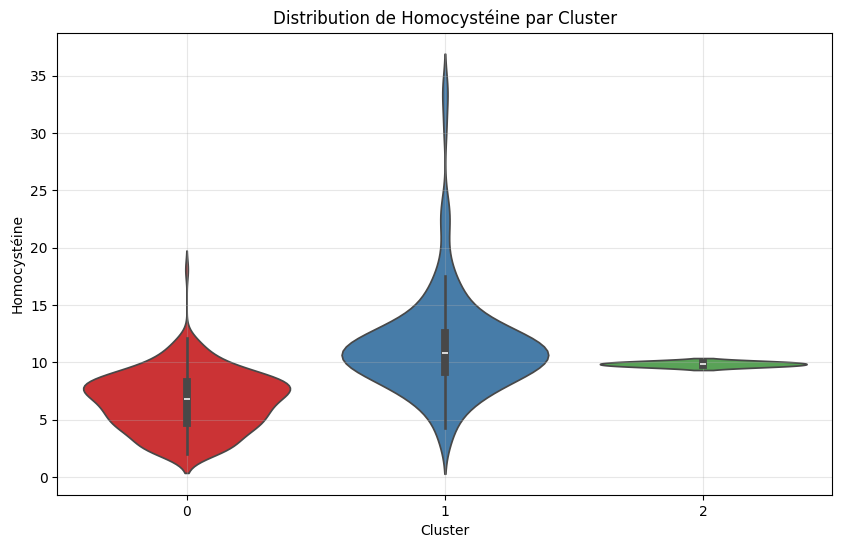

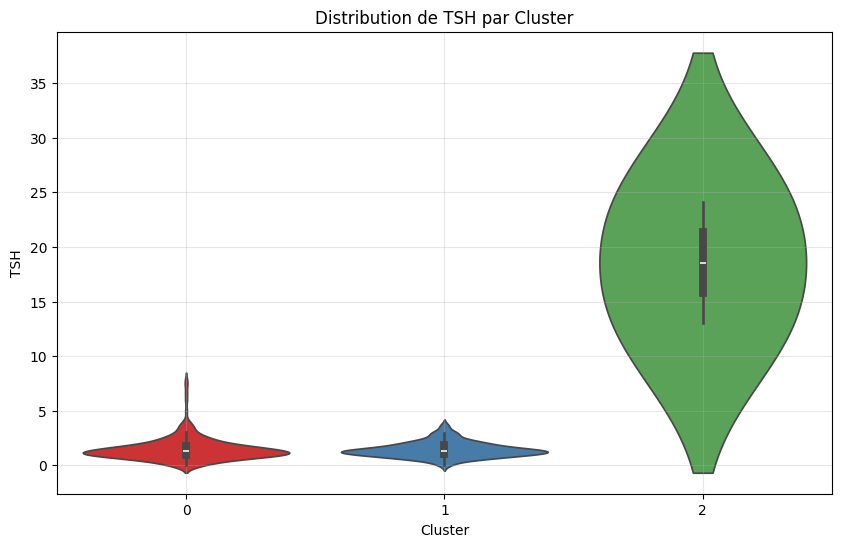

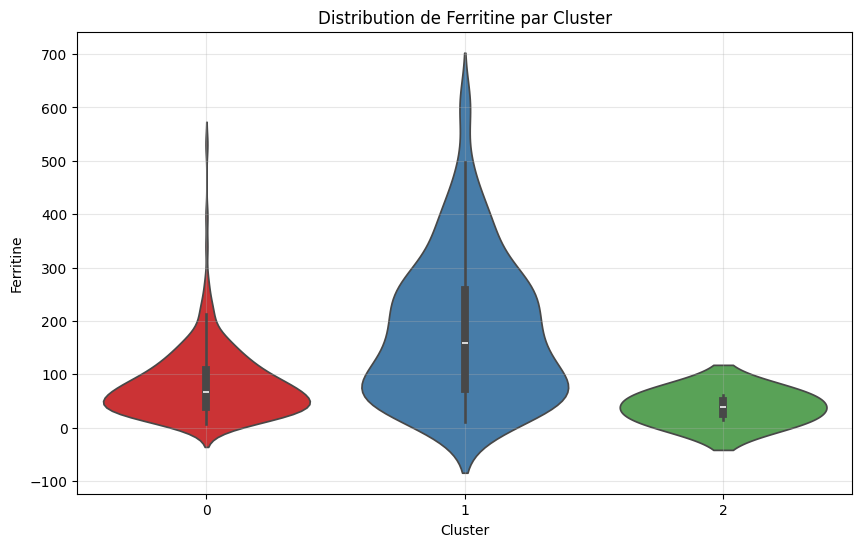

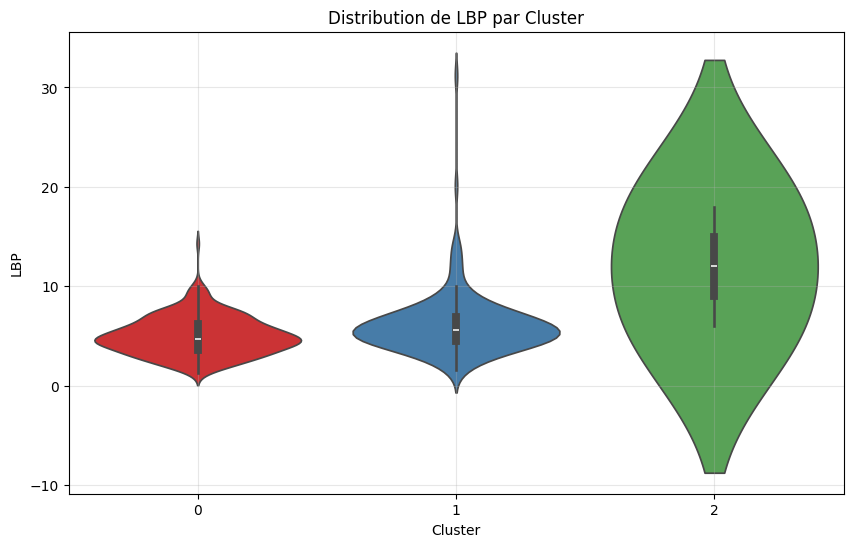

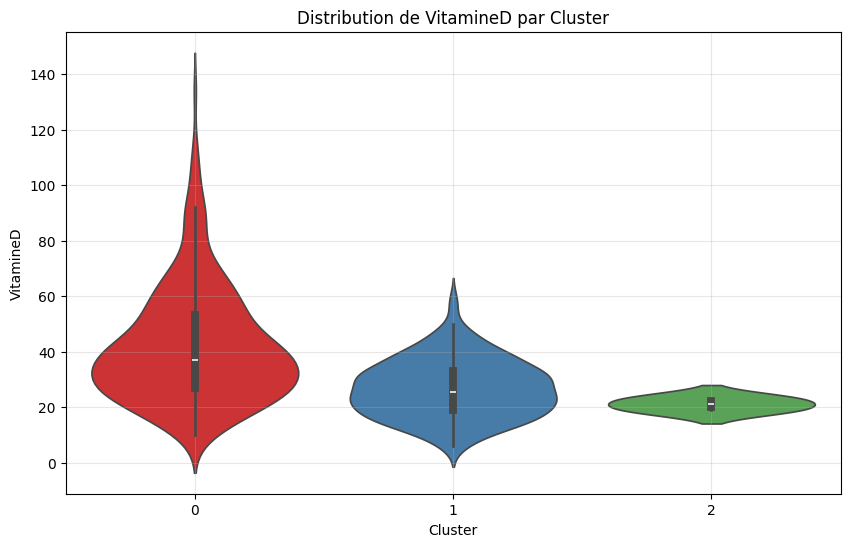

In [59]:
for var in variables:
    simple_violin_plot(new_df,var,'Cluster_Hierarchical')

Data loaded from DataFrame - Shape: (427, 7)

--- PREPARING CLUSTERING DATA ---
Original data shape: (427, 7)
Available columns: ['Année', 'Mois', 'Homocystéine', 'TSH', 'Ferritine', 'LBP', 'VitamineD']
Specified variables for clustering: ['Homocystéine', 'TSH', 'Ferritine', 'LBP', 'VitamineD']
Final clustering data shape: (427, 5)
Variables used for clustering: ['Homocystéine', 'TSH', 'Ferritine', 'LBP', 'VitamineD']
--- DATA VALIDATION ---
Data shape: (427, 5)
Columns: ['Homocystéine', 'TSH', 'Ferritine', 'LBP', 'VitamineD']
Final data shape for clustering: (427, 5)
CLUSTERING WITH 4 CLUSTERS
Preprocessing data...
Original data shape: (427, 5)
Variables: ['Homocystéine', 'TSH', 'Ferritine', 'LBP', 'VitamineD']
Data standardized successfully.

--- K-MEANS CLUSTERING (K=2) ---
Silhouette Score: 0.230
Calinski-Harabasz Score: 88.704
Davies-Bouldin Score: 1.824

Cluster distribution:
  Cluster 0: 161 points (37.7%)
  Cluster 1: 266 points (62.3%)

--- HIERARCHICAL CLUSTERING (K=2, linkag

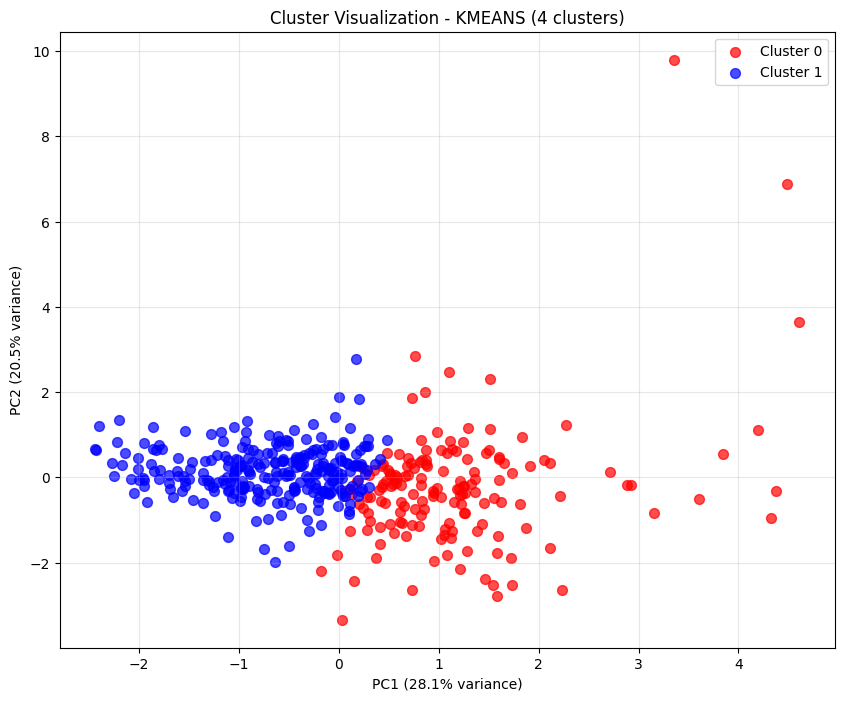

Total variance explained: 48.6%


In [16]:
exporter = ClusterDataExporter(dataframe=df, variables= variables)
donnees_avec_clusters = exporter.get_all_clustered_data(n_clusters=2)
exporter.save_clustered_data('mes_donnees_clusters.csv', 'kmeans')
exporter.show_cluster_profiles('kmeans')
exporter.visualize_clusters('kmeans')

5-Variable Cluster Analysis

DESCRIPTIVE STATISTICS
       Variable_1  Variable_2  Variable_3  Variable_4  Variable_5
count     300.000     300.000     300.000     300.000     300.000
mean       39.983      40.003      40.210      40.332      57.303
std        17.147      21.823      19.778      18.287      18.054
min        10.240       7.048       1.206      15.434      26.901
25%        22.670      22.805      17.848      26.234      43.117
50%        40.516      30.803      45.464      31.551      51.222
75%        57.004      65.488      58.388      61.706      76.840
max        74.418      81.367      70.073      77.437      94.095

CORRELATION MATRIX:
----------------------------------------
            Variable_1  Variable_2  Variable_3  Variable_4  Variable_5
Variable_1       1.000       0.699       0.622       0.849       0.895
Variable_2       0.699       1.000      -0.001       0.893       0.840
Variable_3       0.622      -0.001       1.000       0.280       0.423
Variable

    K  Inertia  Silhouette  Calinski-Harabasz  Davies-Bouldin
0   2  477.602       0.642            637.925           0.527
1   3  101.457       0.746           2047.012           0.356
2   4   95.037       0.542           1458.621           1.240
3   5   88.320       0.357           1178.801           1.693
4   6   83.774       0.161            994.035           2.022
5   7   79.578       0.161            871.643           1.930
6   8   75.375       0.163            788.419           1.798
7   9   72.329       0.155            717.986           1.780
8  10   69.485       0.148            663.375           1.726

Optimal K suggestions:
Silhouette Score: K = 3
Calinski-Harabasz: K = 3
Davies-Bouldin: K = 3

K-MEANS CLUSTERING (K=3)
Silhouette Score: 0.746
Calinski-Harabasz Score: 2047.012
Davies-Bouldin Score: 0.356

Cluster Centers (standardized):
           Variable_1  Variable_2  Variable_3  Variable_4  Variable_5
Cluster_0       1.174       1.346       0.266       1.355       1.311


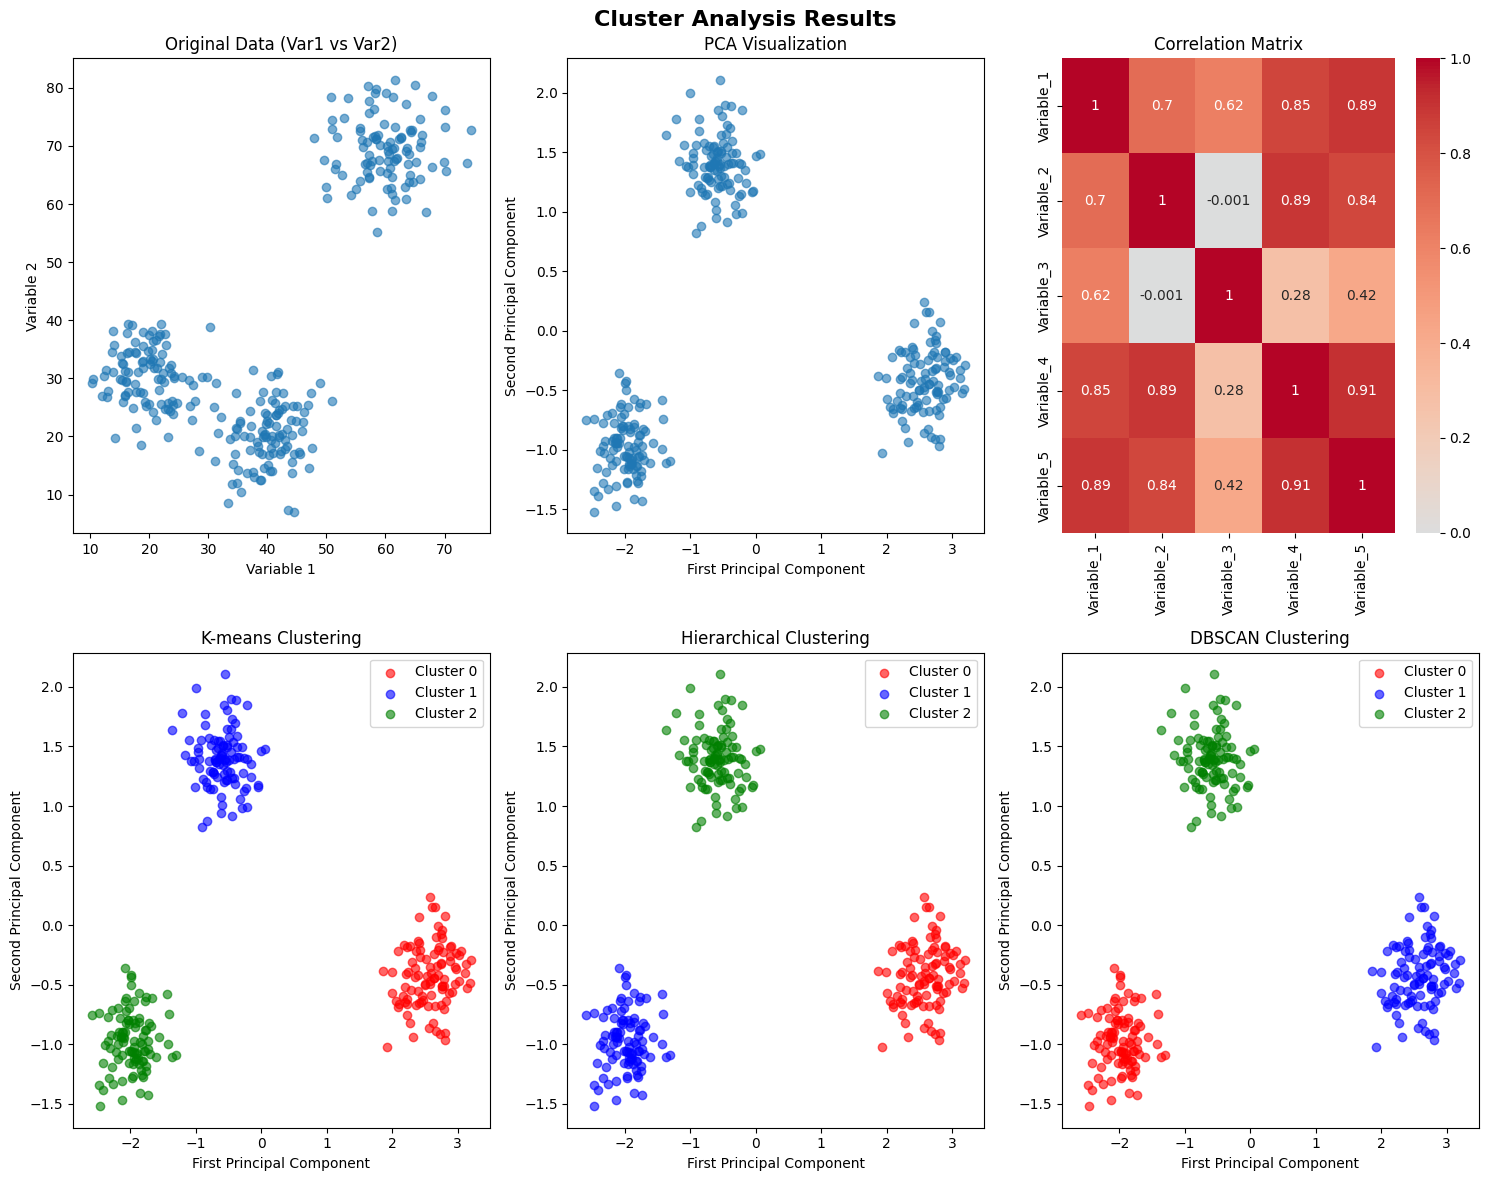


Analysis completed! Check the plots for visual results.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

class ClusterAnalysis:
    def __init__(self, data=None):
        """
        Initialize cluster analysis with data containing 5 quantitative variables
        
        Parameters:
        data: DataFrame with 5 quantitative columns, or None to generate sample data
        """
        if data is None:
            self.data = self.generate_sample_data()
        else:
            self.data = data
        
        self.scaled_data = None
        self.pca_data = None
        self.cluster_results = {}
        
    def generate_sample_data(self, n_samples=300):
        """Generate sample data with 5 quantitative variables"""
        np.random.seed(42)
        
        # Create 3 natural clusters
        cluster1 = np.random.multivariate_normal([20, 30, 15, 25, 40], 
                                                np.eye(5) * 25, 100)
        cluster2 = np.random.multivariate_normal([60, 70, 45, 65, 80], 
                                                np.eye(5) * 30, 100)
        cluster3 = np.random.multivariate_normal([40, 20, 60, 30, 50], 
                                                np.eye(5) * 20, 100)
        
        data = np.vstack([cluster1, cluster2, cluster3])
        
        # Add some noise points
        noise = np.random.uniform(0, 100, (n_samples - 300, 5))
        data = np.vstack([data, noise])
        
        # Create DataFrame
        df = pd.DataFrame(data, columns=['Variable_1', 'Variable_2', 'Variable_3', 
                                       'Variable_4', 'Variable_5'])
        
        # Ensure all values are positive
        df = df.abs()
        
        return df
    
    def preprocess_data(self):
        """Standardize the data and perform PCA"""
        # Standardize the data
        scaler = StandardScaler()
        self.scaled_data = scaler.fit_transform(self.data)
        
        # PCA for visualization (reduce to 2D)
        pca = PCA(n_components=2)
        self.pca_data = pca.fit_transform(self.scaled_data)
        
        print("Data preprocessing completed:")
        print(f"Original data shape: {self.data.shape}")
        print(f"Explained variance ratio (PC1, PC2): {pca.explained_variance_ratio_}")
        print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")
        
        return scaler, pca
    
    def descriptive_statistics(self):
        """Display descriptive statistics for all variables"""
        print("\n" + "="*60)
        print("DESCRIPTIVE STATISTICS")
        print("="*60)
        
        desc_stats = self.data.describe()
        print(desc_stats.round(3))
        
        # Correlation matrix
        print("\nCORRELATION MATRIX:")
        print("-"*40)
        corr_matrix = self.data.corr()
        print(corr_matrix.round(3))
        
        return desc_stats, corr_matrix
    
    def find_optimal_clusters(self, max_k=10):
        """Find optimal number of clusters using multiple methods"""
        if self.scaled_data is None:
            self.preprocess_data()
        
        print("\n" + "="*60)
        print("OPTIMAL NUMBER OF CLUSTERS ANALYSIS")
        print("="*60)
        
        k_range = range(2, max_k + 1)
        inertias = []
        silhouette_scores = []
        calinski_scores = []
        davies_bouldin_scores = []
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(self.scaled_data)
            
            inertias.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(self.scaled_data, labels))
            calinski_scores.append(calinski_harabasz_score(self.scaled_data, labels))
            davies_bouldin_scores.append(davies_bouldin_score(self.scaled_data, labels))
        
        # Print results
        results_df = pd.DataFrame({
            'K': k_range,
            'Inertia': inertias,
            'Silhouette': silhouette_scores,
            'Calinski-Harabasz': calinski_scores,
            'Davies-Bouldin': davies_bouldin_scores
        })
        
        print(results_df.round(3))
        
        # Find optimal k
        optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
        optimal_k_calinski = k_range[np.argmax(calinski_scores)]
        optimal_k_davies = k_range[np.argmin(davies_bouldin_scores)]
        
        print(f"\nOptimal K suggestions:")
        print(f"Silhouette Score: K = {optimal_k_silhouette}")
        print(f"Calinski-Harabasz: K = {optimal_k_calinski}")
        print(f"Davies-Bouldin: K = {optimal_k_davies}")
        
        return results_df
    
    def perform_kmeans(self, n_clusters=3):
        """Perform K-means clustering"""
        if self.scaled_data is None:
            self.preprocess_data()
        
        print(f"\n" + "="*60)
        print(f"K-MEANS CLUSTERING (K={n_clusters})")
        print("="*60)
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(self.scaled_data)
        
        # Add cluster labels to original data
        result_data = self.data.copy()
        result_data['Cluster'] = labels
        
        # Calculate metrics
        silhouette = silhouette_score(self.scaled_data, labels)
        calinski = calinski_harabasz_score(self.scaled_data, labels)
        davies_bouldin = davies_bouldin_score(self.scaled_data, labels)
        
        print(f"Silhouette Score: {silhouette:.3f}")
        print(f"Calinski-Harabasz Score: {calinski:.3f}")
        print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")
        
        # Cluster centers
        centers = pd.DataFrame(kmeans.cluster_centers_, 
                             columns=self.data.columns,
                             index=[f'Cluster_{i}' for i in range(n_clusters)])
        print(f"\nCluster Centers (standardized):")
        print(centers.round(3))
        
        # Cluster sizes
        cluster_sizes = pd.Series(labels).value_counts().sort_index()
        print(f"\nCluster Sizes:")
        for i, size in enumerate(cluster_sizes):
            print(f"Cluster {i}: {size} points ({size/len(labels)*100:.1f}%)")
        
        self.cluster_results['kmeans'] = {
            'labels': labels,
            'data': result_data,
            'centers': centers,
            'metrics': {'silhouette': silhouette, 'calinski': calinski, 'davies_bouldin': davies_bouldin}
        }
        
        return result_data, labels
    
    def perform_hierarchical(self, n_clusters=3, linkage_method='ward'):
        """Perform hierarchical clustering"""
        if self.scaled_data is None:
            self.preprocess_data()
        
        print(f"\n" + "="*60)
        print(f"HIERARCHICAL CLUSTERING (K={n_clusters}, linkage={linkage_method})")
        print("="*60)
        
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
        labels = hierarchical.fit_predict(self.scaled_data)
        
        # Add cluster labels to original data
        result_data = self.data.copy()
        result_data['Cluster'] = labels
        
        # Calculate metrics
        silhouette = silhouette_score(self.scaled_data, labels)
        calinski = calinski_harabasz_score(self.scaled_data, labels)
        davies_bouldin = davies_bouldin_score(self.scaled_data, labels)
        
        print(f"Silhouette Score: {silhouette:.3f}")
        print(f"Calinski-Harabasz Score: {calinski:.3f}")
        print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")
        
        # Cluster sizes
        cluster_sizes = pd.Series(labels).value_counts().sort_index()
        print(f"\nCluster Sizes:")
        for i, size in enumerate(cluster_sizes):
            print(f"Cluster {i}: {size} points ({size/len(labels)*100:.1f}%)")
        
        self.cluster_results['hierarchical'] = {
            'labels': labels,
            'data': result_data,
            'metrics': {'silhouette': silhouette, 'calinski': calinski, 'davies_bouldin': davies_bouldin}
        }
        
        return result_data, labels
    
    def perform_dbscan(self, eps=0.5, min_samples=5):
        """Perform DBSCAN clustering"""
        if self.scaled_data is None:
            self.preprocess_data()
        
        print(f"\n" + "="*60)
        print(f"DBSCAN CLUSTERING (eps={eps}, min_samples={min_samples})")
        print("="*60)
        
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(self.scaled_data)
        
        # Add cluster labels to original data
        result_data = self.data.copy()
        result_data['Cluster'] = labels
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        print(f"Number of clusters: {n_clusters}")
        print(f"Number of noise points: {n_noise}")
        
        if n_clusters > 1:
            # Calculate metrics (excluding noise points)
            mask = labels != -1
            if mask.sum() > 0:
                silhouette = silhouette_score(self.scaled_data[mask], labels[mask])
                calinski = calinski_harabasz_score(self.scaled_data[mask], labels[mask])
                davies_bouldin = davies_bouldin_score(self.scaled_data[mask], labels[mask])
                
                print(f"Silhouette Score: {silhouette:.3f}")
                print(f"Calinski-Harabasz Score: {calinski:.3f}")
                print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")
            
            # Cluster sizes
            cluster_sizes = pd.Series(labels).value_counts().sort_index()
            print(f"\nCluster Sizes:")
            for cluster_id, size in cluster_sizes.items():
                if cluster_id == -1:
                    print(f"Noise: {size} points ({size/len(labels)*100:.1f}%)")
                else:
                    print(f"Cluster {cluster_id}: {size} points ({size/len(labels)*100:.1f}%)")
        
        self.cluster_results['dbscan'] = {
            'labels': labels,
            'data': result_data,
            'n_clusters': n_clusters,
            'n_noise': n_noise
        }
        
        return result_data, labels
    
    def plot_results(self, figsize=(15, 12)):
        """Create comprehensive visualizations"""
        if self.pca_data is None:
            self.preprocess_data()
        
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle('Cluster Analysis Results', fontsize=16, fontweight='bold')
        
        # Original data (first two variables)
        axes[0, 0].scatter(self.data.iloc[:, 0], self.data.iloc[:, 1], alpha=0.6)
        axes[0, 0].set_title('Original Data (Var1 vs Var2)')
        axes[0, 0].set_xlabel('Variable 1')
        axes[0, 0].set_ylabel('Variable 2')
        
        # PCA visualization
        axes[0, 1].scatter(self.pca_data[:, 0], self.pca_data[:, 1], alpha=0.6)
        axes[0, 1].set_title('PCA Visualization')
        axes[0, 1].set_xlabel('First Principal Component')
        axes[0, 1].set_ylabel('Second Principal Component')
        
        # Correlation heatmap
        corr_matrix = self.data.corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0, 2])
        axes[0, 2].set_title('Correlation Matrix')
        
        # Clustering results
        colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
        
        # K-means results
        if 'kmeans' in self.cluster_results:
            labels = self.cluster_results['kmeans']['labels']
            for i in range(len(set(labels))):
                mask = labels == i
                axes[1, 0].scatter(self.pca_data[mask, 0], self.pca_data[mask, 1], 
                                 c=colors[i], label=f'Cluster {i}', alpha=0.6)
            axes[1, 0].set_title('K-means Clustering')
            axes[1, 0].set_xlabel('First Principal Component')
            axes[1, 0].set_ylabel('Second Principal Component')
            axes[1, 0].legend()
        
        # Hierarchical clustering results
        if 'hierarchical' in self.cluster_results:
            labels = self.cluster_results['hierarchical']['labels']
            for i in range(len(set(labels))):
                mask = labels == i
                axes[1, 1].scatter(self.pca_data[mask, 0], self.pca_data[mask, 1], 
                                 c=colors[i], label=f'Cluster {i}', alpha=0.6)
            axes[1, 1].set_title('Hierarchical Clustering')
            axes[1, 1].set_xlabel('First Principal Component')
            axes[1, 1].set_ylabel('Second Principal Component')
            axes[1, 1].legend()
        
        # DBSCAN results
        if 'dbscan' in self.cluster_results:
            labels = self.cluster_results['dbscan']['labels']
            unique_labels = set(labels)
            for i, label in enumerate(unique_labels):
                if label == -1:
                    # Noise points
                    mask = labels == label
                    axes[1, 2].scatter(self.pca_data[mask, 0], self.pca_data[mask, 1], 
                                     c='black', marker='x', label='Noise', alpha=0.6)
                else:
                    mask = labels == label
                    axes[1, 2].scatter(self.pca_data[mask, 0], self.pca_data[mask, 1], 
                                     c=colors[label % len(colors)], label=f'Cluster {label}', alpha=0.6)
            axes[1, 2].set_title('DBSCAN Clustering')
            axes[1, 2].set_xlabel('First Principal Component')
            axes[1, 2].set_ylabel('Second Principal Component')
            axes[1, 2].legend()
        
        plt.tight_layout()
        plt.show()
    
    def cluster_profiling(self, method='kmeans'):
        """Profile clusters by showing mean values for each variable"""
        if method not in self.cluster_results:
            print(f"No results found for {method}. Please run the clustering first.")
            return
        
        result_data = self.cluster_results[method]['data']
        
        print(f"\n" + "="*60)
        print(f"CLUSTER PROFILING - {method.upper()}")
        print("="*60)
        
        # Calculate mean values for each cluster
        cluster_profiles = result_data.groupby('Cluster').agg({
            col: ['mean', 'std', 'count'] for col in self.data.columns
        }).round(3)
        
        print("Cluster Profiles (Mean ± Std, Count):")
        print("-" * 40)
        
        for cluster in sorted(result_data['Cluster'].unique()):
            if cluster == -1:  # DBSCAN noise
                continue
            print(f"\nCluster {cluster}:")
            for var in self.data.columns:
                mean_val = cluster_profiles.loc[cluster, (var, 'mean')]
                std_val = cluster_profiles.loc[cluster, (var, 'std')]
                count_val = int(cluster_profiles.loc[cluster, (var, 'count')])
                print(f"  {var}: {mean_val:.2f} ± {std_val:.2f} (n={count_val})")
        
        return cluster_profiles
    
    def compare_methods(self):
        """Compare different clustering methods"""
        print(f"\n" + "="*60)
        print("CLUSTERING METHODS COMPARISON")
        print("="*60)
        
        comparison_data = []
        
        for method, results in self.cluster_results.items():
            if 'metrics' in results:
                comparison_data.append({
                    'Method': method.capitalize(),
                    'Silhouette': results['metrics']['silhouette'],
                    'Calinski-Harabasz': results['metrics']['calinski'],
                    'Davies-Bouldin': results['metrics']['davies_bouldin'],
                    'N_Clusters': len(set(results['labels'])) - (1 if -1 in results['labels'] else 0)
                })
        
        if comparison_data:
            comparison_df = pd.DataFrame(comparison_data)
            print(comparison_df.round(3))
            
            # Determine best method for each metric
            best_silhouette = comparison_df.loc[comparison_df['Silhouette'].idxmax(), 'Method']
            best_calinski = comparison_df.loc[comparison_df['Calinski-Harabasz'].idxmax(), 'Method']
            best_davies = comparison_df.loc[comparison_df['Davies-Bouldin'].idxmin(), 'Method']
            
            print(f"\nBest methods:")
            print(f"Highest Silhouette Score: {best_silhouette}")
            print(f"Highest Calinski-Harabasz: {best_calinski}")
            print(f"Lowest Davies-Bouldin: {best_davies}")
        
        return comparison_data

# Example usage
if __name__ == "__main__":
    # Initialize cluster analysis
    print("5-Variable Cluster Analysis")
    print("="*60)
    
    # Create instance (using sample data)
    cluster_analyzer = ClusterAnalysis()
    
    # Show descriptive statistics
    cluster_analyzer.descriptive_statistics()
    
    # Find optimal number of clusters
    cluster_analyzer.find_optimal_clusters()
    
    # Perform different clustering methods
    cluster_analyzer.perform_kmeans(n_clusters=3)
    cluster_analyzer.perform_hierarchical(n_clusters=3)
    cluster_analyzer.perform_dbscan(eps=0.8, min_samples=5)
    
    # Compare methods
    cluster_analyzer.compare_methods()
    
    # Profile clusters
    cluster_analyzer.cluster_profiling('kmeans')
    
    # Create visualizations
    cluster_analyzer.plot_results()
    
    print("\n" + "="*60)
    print("Analysis completed! Check the plots for visual results.")
    print("="*60)

# To use with your own data:
# your_data = pd.read_csv('your_file.csv')  # Load your 5-variable dataset
# analyzer = ClusterAnalysis(your_data)
# analyzer.descriptive_statistics()
# analyzer.find_optimal_clusters()
# analyzer.perform_kmeans(n_clusters=3)
# analyzer.plot_results()

In [9]:
analyzer.find_optimal_clusters()


OPTIMAL NUMBER OF CLUSTERS ANALYSIS
    K   Inertia  Silhouette  Calinski-Harabasz  Davies-Bouldin
0   2  1766.339       0.230             88.704           1.824
1   3  1512.920       0.229             87.176           1.363
2   4  1288.678       0.235             92.600           1.260
3   5  1089.947       0.223            101.154           1.176
4   6   980.297       0.216             99.180           1.205
5   7   881.232       0.216             99.592           1.106
6   8   811.459       0.234             97.631           0.956
7   9   746.078       0.208             97.270           1.036
8  10   707.183       0.184             93.548           1.137

Optimal K suggestions:
Silhouette Score: K = 4
Calinski-Harabasz: K = 5
Davies-Bouldin: K = 8


,K,Inertia,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,2,1766.338594,0.230086,88.703886,1.824356
1,3,1512.920036,0.228615,87.175555,1.362571
2,4,1288.677599,0.235240,92.599932,1.260045
3,5,1089.947256,0.222791,101.154495,1.175962
4,6,980.297030,0.215964,99.180133,1.205057
5,7,881.231578,0.215759,99.592198,1.105939
6,8,811.458866,0.233632,97.630815,0.956346
7,9,746.078117,0.208489,97.270201,1.036254
8,10,707.182965,0.183869,93.547958,1.136785



DESCRIPTIVE STATISTICS
       Homocystéine      TSH  Ferritine      LBP  VitamineD
count       427.000  427.000    427.000  427.000    427.000
mean          8.466    1.551    119.553    5.458     36.111
std           4.105    1.539    107.382    2.599     19.081
min           2.000    0.010      6.000    1.300      6.000
25%           5.900    0.950     45.000    4.000     23.000
50%           8.200    1.300     83.000    5.100     32.000
75%          10.400    1.820    156.000    6.500     44.000
max          33.700   24.110    607.000   31.200    134.000

CORRELATION MATRIX:
----------------------------------------
              Homocystéine    TSH  Ferritine    LBP  VitamineD
Homocystéine         1.000  0.052      0.156  0.287     -0.151
TSH                  0.052  1.000      0.005  0.076     -0.010
Ferritine            0.156  0.005      1.000  0.005     -0.030
LBP                  0.287  0.076      0.005  1.000     -0.056
VitamineD           -0.151 -0.010     -0.030 -0.056      1.

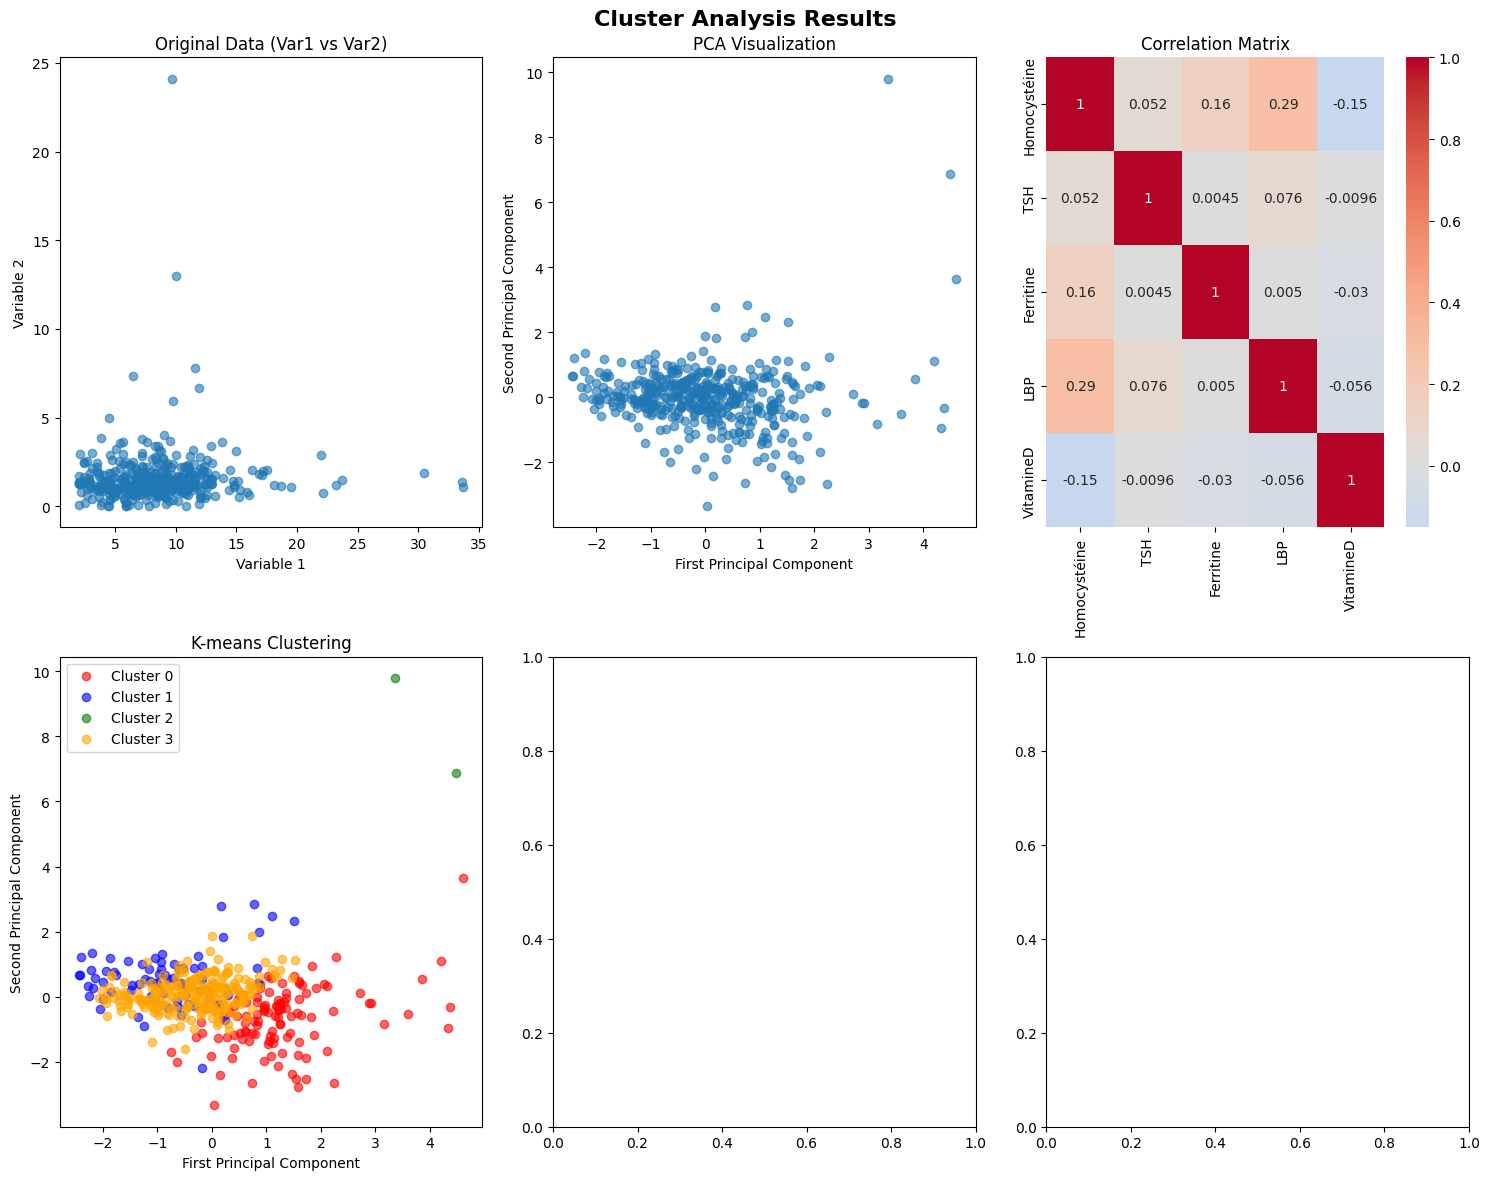

In [10]:
# To use with your own data:
your_data = df.filter(variables)# Load your 5-variable dataset
analyzer = ClusterAnalysis(your_data)
analyzer.descriptive_statistics()
analyzer.find_optimal_clusters()
analyzer.perform_kmeans(n_clusters=4)
analyzer.plot_results()

In [ ]:

    
    
    
    # Show descriptive statistics
    cluster_analyzer.descriptive_statistics()
    
    # Find optimal number of clusters
    cluster_analyzer.find_optimal_clusters()
    
    # Perform different clustering methods
    cluster_analyzer.perform_kmeans(n_clusters=3)
    cluster_analyzer.perform_hierarchical(n_clusters=3)
    cluster_analyzer.perform_dbscan(eps=0.8, min_samples=5)
    
    # Compare methods
    cluster_analyzer.compare_methods()
    
    # Profile clusters
    cluster_analyzer.cluster_profiling('kmeans')
    
    # Create visualizations
    cluster_analyzer.plot_results()
    
    print("\n" + "="*60)
    print("Analysis completed! Check the plots for visual results.")
    print("="*60)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

class ClusterDataExporter:
    def __init__(self, data_file=None):
        """
        Initialize with your data file
        
        Parameters:
        data_file: str, path to your CSV file with 5 quantitative variables
        """
        if data_file:
            self.data = pd.read_csv(data_file)
        else:
            # Generate sample data for testing
            self.data = self.generate_sample_data()
        
        self.scaled_data = None
        self.clustered_data = {}
        
    def generate_sample_data(self, n_samples=300):
        """Generate sample data for testing"""
        np.random.seed(42)
        
        # Create 4 natural clusters for testing
        cluster1 = np.random.multivariate_normal([20, 30, 15, 25, 40], np.eye(5) * 20, 75)
        cluster2 = np.random.multivariate_normal([60, 70, 45, 65, 80], np.eye(5) * 25, 75)
        cluster3 = np.random.multivariate_normal([40, 20, 60, 30, 50], np.eye(5) * 15, 75)
        cluster4 = np.random.multivariate_normal([80, 40, 30, 80, 20], np.eye(5) * 30, 75)
        
        data = np.vstack([cluster1, cluster2, cluster3, cluster4])
        
        df = pd.DataFrame(data, columns=['Variable_1', 'Variable_2', 'Variable_3', 
                                       'Variable_4', 'Variable_5'])
        df = df.abs()  # Ensure positive values
        
        return df
    
    def preprocess_data(self):
        """Standardize the data"""
        print("Preprocessing data...")
        print(f"Original data shape: {self.data.shape}")
        print(f"Variables: {list(self.data.columns)}")
        
        scaler = StandardScaler()
        self.scaled_data = scaler.fit_transform(self.data)
        
        print("Data standardized successfully.")
        return scaler
    
    def cluster_with_kmeans(self, n_clusters=4):
        """Perform K-means clustering with 4 clusters"""
        if self.scaled_data is None:
            self.preprocess_data()
        
        print(f"\n--- K-MEANS CLUSTERING (K={n_clusters}) ---")
        
        # Perform K-means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(self.scaled_data)
        
        # Create result dataframe
        result_df = self.data.copy()
        result_df['Cluster_KMeans'] = cluster_labels
        
        # Calculate quality metrics
        silhouette = silhouette_score(self.scaled_data, cluster_labels)
        calinski = calinski_harabasz_score(self.scaled_data, cluster_labels)
        davies_bouldin = davies_bouldin_score(self.scaled_data, cluster_labels)
        
        print(f"Silhouette Score: {silhouette:.3f}")
        print(f"Calinski-Harabasz Score: {calinski:.3f}")
        print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")
        
        # Show cluster distribution
        cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
        print(f"\nCluster distribution:")
        for cluster, count in cluster_counts.items():
            percentage = (count / len(cluster_labels)) * 100
            print(f"  Cluster {cluster}: {count} points ({percentage:.1f}%)")
        
        self.clustered_data['kmeans'] = result_df
        return result_df
    
    def cluster_with_hierarchical(self, n_clusters=4, linkage='ward'):
        """Perform Hierarchical clustering with 4 clusters"""
        if self.scaled_data is None:
            self.preprocess_data()
        
        print(f"\n--- HIERARCHICAL CLUSTERING (K={n_clusters}, linkage={linkage}) ---")
        
        # Perform Hierarchical clustering
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        cluster_labels = hierarchical.fit_predict(self.scaled_data)
        
        # Create result dataframe
        result_df = self.data.copy()
        result_df['Cluster_Hierarchical'] = cluster_labels
        
        # Calculate quality metrics
        silhouette = silhouette_score(self.scaled_data, cluster_labels)
        calinski = calinski_harabasz_score(self.scaled_data, cluster_labels)
        davies_bouldin = davies_bouldin_score(self.scaled_data, cluster_labels)
        
        print(f"Silhouette Score: {silhouette:.3f}")
        print(f"Calinski-Harabasz Score: {calinski:.3f}")
        print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")
        
        # Show cluster distribution
        cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
        print(f"\nCluster distribution:")
        for cluster, count in cluster_counts.items():
            percentage = (count / len(cluster_labels)) * 100
            print(f"  Cluster {cluster}: {count} points ({percentage:.1f}%)")
        
        self.clustered_data['hierarchical'] = result_df
        return result_df
    
    def get_all_clustered_data(self, n_clusters=4):
        """Get data with all clustering methods applied"""
        print("="*60)
        print("CLUSTERING WITH 4 CLUSTERS")
        print("="*60)
        
        # Apply both methods
        kmeans_result = self.cluster_with_kmeans(n_clusters)
        hierarchical_result = self.cluster_with_hierarchical(n_clusters)
        
        # Combine results
        final_result = self.data.copy()
        final_result['Cluster_KMeans'] = kmeans_result['Cluster_KMeans']
        final_result['Cluster_Hierarchical'] = hierarchical_result['Cluster_Hierarchical']
        
        self.clustered_data['combined'] = final_result
        return final_result
    
    def show_cluster_profiles(self, method='kmeans'):
        """Show statistical profile of each cluster"""
        if method not in self.clustered_data:
            print(f"Method {method} not found. Run clustering first.")
            return
        
        data = self.clustered_data[method]
        cluster_col = f'Cluster_{method.capitalize()}' if method != 'combined' else 'Cluster_KMeans'
        
        print(f"\n--- CLUSTER PROFILES ({method.upper()}) ---")
        
        # Calculate profiles
        numeric_cols = [col for col in data.columns if col.startswith('Variable_')]
        profiles = data.groupby(cluster_col)[numeric_cols].agg(['mean', 'std', 'count']).round(3)
        
        for cluster in sorted(data[cluster_col].unique()):
            print(f"\nCluster {cluster}:")
            for var in numeric_cols:
                mean_val = profiles.loc[cluster, (var, 'mean')]
                std_val = profiles.loc[cluster, (var, 'std')]
                count_val = int(profiles.loc[cluster, (var, 'count')])
                print(f"  {var}: {mean_val:.2f} ± {std_val:.2f} (n={count_val})")
    
    def save_clustered_data(self, filename=None, method='kmeans'):
        """Save clustered data to CSV file"""
        if method not in self.clustered_data:
            print(f"Method {method} not found. Run clustering first.")
            return
        
        data_to_save = self.clustered_data[method]
        
        if filename is None:
            filename = f'data_with_{method}_clusters.csv'
        
        data_to_save.to_csv(filename, index=False)
        print(f"\nData saved to: {filename}")
        print(f"Shape: {data_to_save.shape}")
        print(f"Columns: {list(data_to_save.columns)}")
        
        return filename
    
    def visualize_clusters(self, method='kmeans'):
        """Create visualization of clusters using PCA"""
        if method not in self.clustered_data:
            print(f"Method {method} not found. Run clustering first.")
            return
        
        if self.scaled_data is None:
            self.preprocess_data()
        
        # PCA for visualization
        pca = PCA(n_components=2)
        pca_data = pca.fit_transform(self.scaled_data)
        
        data = self.clustered_data[method]
        cluster_col = f'Cluster_{method.capitalize()}' if method != 'combined' else 'Cluster_KMeans'
        
        plt.figure(figsize=(10, 8))
        
        colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
        clusters = sorted(data[cluster_col].unique())
        
        for i, cluster in enumerate(clusters):
            mask = data[cluster_col] == cluster
            plt.scatter(pca_data[mask, 0], pca_data[mask, 1], 
                       c=colors[i % len(colors)], label=f'Cluster {cluster}', 
                       alpha=0.7, s=50)
        
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
        plt.title(f'Cluster Visualization - {method.upper()} (4 clusters)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.1%}")

# Exemple d'utilisation
if __name__ == "__main__":
    
    # ============================================================
    # MÉTHODE 1: Avec vos propres données
    # ============================================================
    print("OPTION 1: Utiliser vos propres données")
    print("Décommentez les lignes suivantes et remplacez 'votre_fichier.csv':")
    print("# exporter = ClusterDataExporter('votre_fichier.csv')")
    print("# donnees_avec_clusters = exporter.get_all_clustered_data(n_clusters=4)")
    print("# exporter.save_clustered_data('mes_donnees_clusterisees.csv', 'kmeans')")
    
    print("\n" + "="*60)
    print("DÉMONSTRATION AVEC DONNÉES D'EXEMPLE")
    print("="*60)
    
    # ============================================================
    # MÉTHODE 2: Démonstration avec données d'exemple
    # ============================================================
    
    # Créer l'instance avec données d'exemple
    exporter = ClusterDataExporter()
    
    # Afficher un aperçu des données originales
    print("\nAperçu des données originales:")
    print(exporter.data.head())
    print(f"\nTaille: {exporter.data.shape}")
    
    # Effectuer le clustering avec 4 clusters
    donnees_avec_clusters = exporter.get_all_clustered_data(n_clusters=4)
    
    # Afficher les profils des clusters
    exporter.show_cluster_profiles('kmeans')
    
    # Sauvegarder les résultats
    fichier_sauve = exporter.save_clustered_data('exemple_donnees_clusterisees.csv', 'kmeans')
    
    # Visualiser les clusters
    exporter.visualize_clusters('kmeans')
    
    # Afficher un aperçu final
    print(f"\n--- APERÇU FINAL DES DONNÉES AVEC CLUSTERS ---")
    print(donnees_avec_clusters.head(10))
    
    print(f"\n--- INSTRUCTIONS POUR VOS DONNÉES ---")
    print("1. Remplacez None par le chemin vers votre fichier CSV:")
    print("   exporter = ClusterDataExporter('mon_fichier.csv')")
    print("2. Lancez le clustering:")
    print("   donnees = exporter.get_all_clustered_data(n_clusters=4)")
    print("3. Sauvegardez:")
    print("   exporter.save_clustered_data('mes_resultats.csv', 'kmeans')")
    
    # ============================================================
    # CODE SIMPLE POUR VOS DONNÉES
    # ============================================================
    print(f"\n" + "="*60)
    print("CODE SIMPLE POUR VOS DONNÉES:")
    print("="*60)
    print("""
# Remplacez 'votre_fichier.csv' par le chemin vers votre fichier
from cluster_analysis import ClusterDataExporter

# Charger vos données et faire le clustering
exporter = ClusterDataExporter('votre_fichier.csv')
donnees_clusterisees = exporter.get_all_clustered_data(n_clusters=4)

# Sauvegarder le résultat
exporter.save_clustered_data('mes_donnees_avec_clusters.csv', 'kmeans')

# Voir les profils des clusters
exporter.show_cluster_profiles('kmeans')

# Visualiser
exporter.visualize_clusters('kmeans')

print("Terminé! Vos données avec les clusters sont dans 'mes_donnees_avec_clusters.csv'")
""")

OPTION 1: Utiliser vos propres données
Décommentez les lignes suivantes et remplacez 'votre_fichier.csv':
# exporter = ClusterDataExporter('votre_fichier.csv')
# donnees_avec_clusters = exporter.get_all_clustered_data(n_clusters=4)
# exporter.save_clustered_data('mes_donnees_clusterisees.csv', 'kmeans')

DÉMONSTRATION AVEC DONNÉES D'EXEMPLE

Aperçu des données originales:
   Variable_1  Variable_2  Variable_3  Variable_4  Variable_5
0   22.221373   29.381663   17.896551   31.811197   38.952834
1   18.952908   37.062454   18.432072   22.900447   42.426402
2   17.927533   27.917193   16.082088   16.443551   32.285933
3   17.485374   25.470482   16.405357   20.939193   33.683986
4   26.554581   28.990298   15.301995   18.628332   37.565446

Taille: (300, 5)
CLUSTERING WITH 4 CLUSTERS
Preprocessing data...
Original data shape: (300, 5)
Variables: ['Variable_1', 'Variable_2', 'Variable_3', 'Variable_4', 'Variable_5']
Data standardized successfully.

--- K-MEANS CLUSTERING (K=4) ---
Silhouet

KeyError: 'Cluster_Kmeans'

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

class ClusterDataExporter:
    def __init__(self, data_file=None, data=None):
        """
        Initialize with your data file or DataFrame
        
        Parameters:
        data_file: str, path to your CSV file with quantitative variables
        data: pd.DataFrame, alternative to data_file for direct DataFrame input
        """
        if data is not None:
            self.data = data.copy()
        elif data_file:
            try:
                self.data = pd.read_csv(data_file)
                print(f"Data loaded successfully from {data_file}")
            except FileNotFoundError:
                print(f"Error: File '{data_file}' not found.")
                print("Generating sample data for demonstration...")
                self.data = self.generate_sample_data()
            except Exception as e:
                print(f"Error reading file: {e}")
                print("Generating sample data for demonstration...")
                self.data = self.generate_sample_data()
        else:
            # Generate sample data for testing
            self.data = self.generate_sample_data()
        
        self.scaled_data = None
        self.clustered_data = {}
        self.scaler = None
        
        # Validate data
        self.validate_data()
        
    def validate_data(self):
        """Validate that data contains only numeric columns"""
        print(f"\n--- DATA VALIDATION ---")
        print(f"Data shape: {self.data.shape}")
        print(f"Columns: {list(self.data.columns)}")
        
        # Check for numeric columns
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns
        non_numeric_cols = self.data.select_dtypes(exclude=[np.number]).columns
        
        if len(non_numeric_cols) > 0:
            print(f"Warning: Non-numeric columns found: {list(non_numeric_cols)}")
            print("These columns will be excluded from clustering.")
            self.data = self.data[numeric_cols]
        
        # Check for missing values
        missing_values = self.data.isnull().sum()
        if missing_values.any():
            print(f"Warning: Missing values found:")
            for col, count in missing_values[missing_values > 0].items():
                print(f"  {col}: {count} missing values")
            print("Missing values will be filled with column means.")
            self.data = self.data.fillna(self.data.mean())
        
        print(f"Final data shape for clustering: {self.data.shape}")
        
    def generate_sample_data(self, n_samples=300):
        """Generate sample data for testing"""
        np.random.seed(42)
        
        # Create 4 natural clusters for testing
        cluster1 = np.random.multivariate_normal([20, 30, 15, 25, 40], np.eye(5) * 20, 75)
        cluster2 = np.random.multivariate_normal([60, 70, 45, 65, 80], np.eye(5) * 25, 75)
        cluster3 = np.random.multivariate_normal([40, 20, 60, 30, 50], np.eye(5) * 15, 75)
        cluster4 = np.random.multivariate_normal([80, 40, 30, 80, 20], np.eye(5) * 30, 75)
        
        data = np.vstack([cluster1, cluster2, cluster3, cluster4])
        
        df = pd.DataFrame(data, columns=['Variable_1', 'Variable_2', 'Variable_3', 
                                       'Variable_4', 'Variable_5'])
        df = df.abs()  # Ensure positive values
        
        return df
    
    def preprocess_data(self):
        """Standardize the data"""
        print("\n--- PREPROCESSING DATA ---")
        print(f"Original data shape: {self.data.shape}")
        print(f"Variables: {list(self.data.columns)}")
        
        # Check for infinite values
        if np.isinf(self.data.values).any():
            print("Warning: Infinite values found. Replacing with NaN and then mean.")
            self.data = self.data.replace([np.inf, -np.inf], np.nan)
            self.data = self.data.fillna(self.data.mean())
        
        self.scaler = StandardScaler()
        self.scaled_data = self.scaler.fit_transform(self.data)
        
        print("Data standardized successfully.")
        
        # Show standardization summary
        print(f"Mean of scaled data: {np.mean(self.scaled_data, axis=0).round(3)}")
        print(f"Std of scaled data: {np.std(self.scaled_data, axis=0).round(3)}")
        
        return self.scaler
    
    def cluster_with_kmeans(self, n_clusters=4):
        """Perform K-means clustering with specified number of clusters"""
        if self.scaled_data is None:
            self.preprocess_data()
        
        print(f"\n--- K-MEANS CLUSTERING (K={n_clusters}) ---")
        
        # Perform K-means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(self.scaled_data)
        
        # Create result dataframe
        result_df = self.data.copy()
        result_df['Cluster_KMeans'] = cluster_labels
        
        # Calculate quality metrics
        silhouette = silhouette_score(self.scaled_data, cluster_labels)
        calinski = calinski_harabasz_score(self.scaled_data, cluster_labels)
        davies_bouldin = davies_bouldin_score(self.scaled_data, cluster_labels)
        
        print(f"Silhouette Score: {silhouette:.3f} (higher is better, range: -1 to 1)")
        print(f"Calinski-Harabasz Score: {calinski:.3f} (higher is better)")
        print(f"Davies-Bouldin Score: {davies_bouldin:.3f} (lower is better)")
        
        # Show cluster distribution
        cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
        print(f"\nCluster distribution:")
        for cluster, count in cluster_counts.items():
            percentage = (count / len(cluster_labels)) * 100
            print(f"  Cluster {cluster}: {count} points ({percentage:.1f}%)")
        
        # Store cluster centers (in original scale)
        cluster_centers_scaled = kmeans.cluster_centers_
        cluster_centers_original = self.scaler.inverse_transform(cluster_centers_scaled)
        centers_df = pd.DataFrame(cluster_centers_original, 
                                columns=self.data.columns,
                                index=[f'Cluster_{i}' for i in range(n_clusters)])
        
        print(f"\nCluster Centers (original scale):")
        print(centers_df.round(3))
        
        self.clustered_data['kmeans'] = {
            'data': result_df,
            'centers': centers_df,
            'metrics': {'silhouette': silhouette, 'calinski': calinski, 'davies_bouldin': davies_bouldin}
        }
        
        return result_df
    
    def cluster_with_hierarchical(self, n_clusters=4, linkage='ward'):
        """Perform Hierarchical clustering with specified number of clusters"""
        if self.scaled_data is None:
            self.preprocess_data()
        
        print(f"\n--- HIERARCHICAL CLUSTERING (K={n_clusters}, linkage={linkage}) ---")
        
        # Perform Hierarchical clustering
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        cluster_labels = hierarchical.fit_predict(self.scaled_data)
        
        # Create result dataframe
        result_df = self.data.copy()
        result_df['Cluster_Hierarchical'] = cluster_labels
        
        # Calculate quality metrics
        silhouette = silhouette_score(self.scaled_data, cluster_labels)
        calinski = calinski_harabasz_score(self.scaled_data, cluster_labels)
        davies_bouldin = davies_bouldin_score(self.scaled_data, cluster_labels)
        
        print(f"Silhouette Score: {silhouette:.3f} (higher is better, range: -1 to 1)")
        print(f"Calinski-Harabasz Score: {calinski:.3f} (higher is better)")
        print(f"Davies-Bouldin Score: {davies_bouldin:.3f} (lower is better)")
        
        # Show cluster distribution
        cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
        print(f"\nCluster distribution:")
        for cluster, count in cluster_counts.items():
            percentage = (count / len(cluster_labels)) * 100
            print(f"  Cluster {cluster}: {count} points ({percentage:.1f}%)")
        
        self.clustered_data['hierarchical'] = {
            'data': result_df,
            'metrics': {'silhouette': silhouette, 'calinski': calinski, 'davies_bouldin': davies_bouldin}
        }
        
        return result_df
    
    def get_all_clustered_data(self, n_clusters=4):
        """Get data with all clustering methods applied"""
        print("="*60)
        print(f"CLUSTERING WITH {n_clusters} CLUSTERS")
        print("="*60)
        
        # Apply both methods
        kmeans_result = self.cluster_with_kmeans(n_clusters)
        hierarchical_result = self.cluster_with_hierarchical(n_clusters)
        
        # Combine results
        final_result = self.data.copy()
        final_result['Cluster_KMeans'] = kmeans_result['Cluster_KMeans']
        final_result['Cluster_Hierarchical'] = hierarchical_result['Cluster_Hierarchical']
        
        self.clustered_data['combined'] = {'data': final_result}
        return final_result
    
    def show_cluster_profiles(self, method='kmeans'):
        """Show statistical profile of each cluster"""
        if method not in self.clustered_data:
            print(f"Method {method} not found. Run clustering first.")
            return
        
        data = self.clustered_data[method]['data']
        cluster_col = f'Cluster_{method.capitalize()}' if method != 'combined' else 'Cluster_KMeans'
        
        print(f"\n--- CLUSTER PROFILES ({method.upper()}) ---")
        
        # Calculate profiles for numeric columns only
        numeric_cols = data.select_dtypes(include=[np.number]).columns
        numeric_cols = [col for col in numeric_cols if not col.startswith('Cluster_')]
        
        profiles = data.groupby(cluster_col)[numeric_cols].agg(['mean', 'std', 'count']).round(3)
        
        for cluster in sorted(data[cluster_col].unique()):
            print(f"\nCluster {cluster}:")
            for var in numeric_cols:
                mean_val = profiles.loc[cluster, (var, 'mean')]
                std_val = profiles.loc[cluster, (var, 'std')]
                count_val = int(profiles.loc[cluster, (var, 'count')])
                print(f"  {var}: {mean_val:.2f} ± {std_val:.2f} (n={count_val})")
        
        return profiles
    
    def save_clustered_data(self, filename=None, method='kmeans'):
        """Save clustered data to CSV file"""
        if method not in self.clustered_data:
            print(f"Method {method} not found. Run clustering first.")
            return None
        
        data_to_save = self.clustered_data[method]['data']
        
        if filename is None:
            filename = f'data_with_{method}_clusters.csv'
        
        try:
            data_to_save.to_csv(filename, index=False)
            print(f"\nData saved successfully to: {filename}")
            print(f"Shape: {data_to_save.shape}")
            print(f"Columns: {list(data_to_save.columns)}")
            return filename
        except Exception as e:
            print(f"Error saving file: {e}")
            return None
    
    def visualize_clusters(self, method='kmeans', figsize=(12, 10)):
        """Create comprehensive visualization of clusters using PCA"""
        if method not in self.clustered_data:
            print(f"Method {method} not found. Run clustering first.")
            return
        
        if self.scaled_data is None:
            self.preprocess_data()
        
        # PCA for visualization
        pca = PCA(n_components=2)
        pca_data = pca.fit_transform(self.scaled_data)
        
        data = self.clustered_data[method]['data']
        cluster_col = f'Cluster_{method.capitalize()}' if method != 'combined' else 'Cluster_KMeans'
        
        # Create subplots
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Plot 1: PCA visualization
        colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
        clusters = sorted(data[cluster_col].unique())
        
        for i, cluster in enumerate(clusters):
            mask = data[cluster_col] == cluster
            axes[0].scatter(pca_data[mask, 0], pca_data[mask, 1], 
                           c=colors[i % len(colors)], label=f'Cluster {cluster}', 
                           alpha=0.7, s=50)
        
        axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
        axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
        axes[0].set_title(f'Cluster Visualization - {method.upper()}')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Cluster sizes
        cluster_counts = data[cluster_col].value_counts().sort_index()
        axes[1].bar(range(len(cluster_counts)), cluster_counts.values, color=colors[:len(cluster_counts)])
        axes[1].set_xlabel('Cluster')
        axes[1].set_ylabel('Number of Points')
        axes[1].set_title('Cluster Sizes')
        axes[1].set_xticks(range(len(cluster_counts)))
        axes[1].set_xticklabels([f'Cluster {i}' for i in cluster_counts.index])
        
        # Add value labels on bars
        for i, v in enumerate(cluster_counts.values):
            axes[1].text(i, v + max(cluster_counts.values) * 0.01, str(v), 
                        ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Total variance explained by PC1 and PC2: {pca.explained_variance_ratio_.sum():.1%}")
        
        return fig
    
    def compare_methods(self):
        """Compare clustering methods based on metrics"""
        print(f"\n--- CLUSTERING METHODS COMPARISON ---")
        
        methods_with_metrics = {k: v for k, v in self.clustered_data.items() 
                               if 'metrics' in v}
        
        if not methods_with_metrics:
            print("No clustering results with metrics found.")
            return None
        
        comparison_data = []
        for method, results in methods_with_metrics.items():
            metrics = results['metrics']
            comparison_data.append({
                'Method': method.capitalize(),
                'Silhouette': metrics['silhouette'],
                'Calinski-Harabasz': metrics['calinski'],
                'Davies-Bouldin': metrics['davies_bouldin']
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df.round(3))
        
        if len(comparison_data) > 1:
            best_silhouette = comparison_df.loc[comparison_df['Silhouette'].idxmax(), 'Method']
            best_calinski = comparison_df.loc[comparison_df['Calinski-Harabasz'].idxmax(), 'Method']
            best_davies = comparison_df.loc[comparison_df['Davies-Bouldin'].idxmin(), 'Method']
            
            print(f"\nBest performing methods:")
            print(f"  Highest Silhouette Score: {best_silhouette}")
            print(f"  Highest Calinski-Harabasz: {best_calinski}")
            print(f"  Lowest Davies-Bouldin: {best_davies}")
        
        return comparison_df

# Test et exemple d'utilisation
if __name__ == "__main__":
    
    print("="*60)
    print("CLUSTER DATA EXPORTER - VERSION AMÉLIORÉE")
    print("="*60)
    
    # Test avec données d'exemple
    print("\n1. CRÉATION D'UNE INSTANCE AVEC DONNÉES D'EXEMPLE")
    exporter = ClusterDataExporter()
    
    print("\n2. APERÇU DES DONNÉES")
    print(exporter.data.head())
    print(f"Forme des données: {exporter.data.shape}")
    
    print("\n3. CLUSTERING AVEC 4 CLUSTERS")
    donnees_avec_clusters = exporter.get_all_clustered_data(n_clusters=4)
    
    print("\n4. PROFILS DES CLUSTERS")
    exporter.show_cluster_profiles('kmeans')
    
    print("\n5. COMPARAISON DES MÉTHODES")
    exporter.compare_methods()
    
    print("\n6. SAUVEGARDE")
    fichier = exporter.save_clustered_data('test_clustering_results.csv', 'kmeans')
    
    print("\n7. VISUALISATION")
    exporter.visualize_clusters('kmeans')
    
    print("\n" + "="*60)
    print("UTILISATION AVEC VOS DONNÉES:")
    print("="*60)
    print("""
# Code simple pour vos données:
exporter = ClusterDataExporter('votre_fichier.csv')
resultat = exporter.get_all_clustered_data(n_clusters=4)
exporter.save_clustered_data('mes_donnees_clusters.csv', 'kmeans')
exporter.show_cluster_profiles('kmeans')
exporter.visualize_clusters('kmeans')
    """)

CLUSTER DATA EXPORTER - VERSION AMÉLIORÉE

1. CRÉATION D'UNE INSTANCE AVEC DONNÉES D'EXEMPLE

--- DATA VALIDATION ---
Data shape: (300, 5)
Columns: ['Variable_1', 'Variable_2', 'Variable_3', 'Variable_4', 'Variable_5']
Final data shape for clustering: (300, 5)

2. APERÇU DES DONNÉES
   Variable_1  Variable_2  Variable_3  Variable_4  Variable_5
0   22.221373   29.381663   17.896551   31.811197   38.952834
1   18.952908   37.062454   18.432072   22.900447   42.426402
2   17.927533   27.917193   16.082088   16.443551   32.285933
3   17.485374   25.470482   16.405357   20.939193   33.683986
4   26.554581   28.990298   15.301995   18.628332   37.565446
Forme des données: (300, 5)

3. CLUSTERING AVEC 4 CLUSTERS
CLUSTERING WITH 4 CLUSTERS

--- PREPROCESSING DATA ---
Original data shape: (300, 5)
Variables: ['Variable_1', 'Variable_2', 'Variable_3', 'Variable_4', 'Variable_5']
Data standardized successfully.
Mean of scaled data: [-0.  0. -0. -0.  0.]
Std of scaled data: [1. 1. 1. 1. 1.]

--- K

KeyError: 'Cluster_Kmeans'